In [1]:
import pandas as pd

In [2]:
import requests
from requests.exceptions import HTTPError, Timeout
import time
import re

class SPARQLResponse():
    def __init__(self, data) -> None:
        self.data = data
        if isinstance(data, dict):
            if "results" in data and "bindings" in data["results"]:
                self.bindings = data['results']['bindings']
                self.success = True
        else:
            self.bindings = False
            self.success = False

def is_query_empty(query :str) -> bool:
    query = query.strip()
    return query is None or query == "" or len(query) == 0

# Modified from the original file to suit this notebook, but has the same functionality
def send_query_to_api(query, timeout_limit=60, num_try=3):
    response = None
    while num_try > 0 and response == None and not is_query_empty(query):
        try:
            sparql_response = execute_sparql(query, timeout=timeout_limit)
            response = sparql_response.bindings if sparql_response.success else sparql_response.data
                
        except HTTPError as inst:
            if inst.response.status_code == 429:
                retry_after = int(inst.response.headers['retry-after'])
                time.sleep(retry_after + 1)
                num_try -= 1
            else:
                response = "exception: " + str(inst) + "\n" + inst.response.text
        except Timeout:
            response = "timeout"
        except Exception as inst:
            response = "exception: " + str(inst)
    return response if response != None else "exception: too many retry-after"

def execute_sparql(query: str, timeout: int = None):
    url = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql'
    response = requests.get(url, params={'query': query, 'format': 'json'}, headers={'User-agent': 'WikidataLLM bot v0'}, timeout=timeout)
    response.raise_for_status()
    
    try:
        data = SPARQLResponse(response.json())
    except requests.exceptions.JSONDecodeError:
        data = SPARQLResponse(response.text)
    
    return data

def find_error_type(x: str):
    if not isinstance(x, str):
        return None
    
    http_error = re.compile(r"exception: ([0-9]+)")
    module_request_error = re.compile(r"exception: module 'requests.exceptions'")
    invalid_json_error = re.compile(r"Connection broken: InvalidChunkLength")
    server_timeout_error = re.compile(r"java.util.concurrent.TimeoutException")
    
    http_error_match = http_error.search(x[:20])
    
    if http_error_match != None:
        return http_error_match.group(1)
    
    if module_request_error.search(x[:50]):
        return "requests"
    
    if invalid_json_error.search(x[:100]):
        return "invalid JSON"
    
    if server_timeout_error.search(x[len(x)-10000:]):
        return "server timeout"
    
    return None

def generate_index_of_errors(all_errors: pd.Series):
    error_types = sorted(list(all_errors.value_counts().index))
    return {x[0]: i for i, x in enumerate(error_types)}

def classify_400_errors(stack_trace: str):
    pattern = re.compile(r"Caused by: .+")
    pattern_undefined_prefix = re.compile(r"undefined prefix")
    pattern_parse = re.compile(r"ast.ParseException")
    pattern_limit = re.compile(r"limit|LIMIT")
    pattern_lexical = re.compile(r"Lexical error")
    pattern_non_agg_var_in_sel = re.compile(r"Non-aggregate variable in select expression")
    pattern_multiple_same_prefixes = re.compile(r"Multiple prefix declarations for prefix")
    
    reduced_stack = pattern.findall(stack_trace)
    last_error = reduced_stack[len(reduced_stack)-1]
    
    errors = []
    if pattern_undefined_prefix.search(last_error):
        errors.append("undefined prefix")
    if pattern_parse.search(last_error):
        if pattern_limit.search(last_error):
            errors.append("parse exception due to limit")
        else:
            errors.append("parse exception")
    if pattern_lexical.search(last_error):
        errors.append("lexical error")
    if pattern_non_agg_var_in_sel.search(last_error):
        errors.append("non-aggregate variable in select expression")
    if pattern_multiple_same_prefixes.search(last_error):
        errors.append("Prefix duplicates")
        
    return errors

def send_and_classify_400_errors(query: str):
    response = send_query_to_api(query)
    if isinstance(response, list):
        return ['false negative']
    else:
        stack = response.split("\n", maxsplit=1)[1]
        return classify_400_errors(stack)

def classify_500_errors(stack_trace: str):
    pattern = re.compile(r"Caused by: .+")
    pattern_stackoverflow = re.compile(r"StackOverflowError")
    pattern_geo_input_no_resolve_point = re.compile(r"Input could not be resolved as point")
    pattern_estimated_time_too_long = re.compile(r"The estimated execution time")
    pattern_out_of_memory = re.compile(r"MemoryManagerOutOfMemory")
    
    reduced_stack = pattern.findall(stack_trace)
    last_error = reduced_stack[len(reduced_stack)-1]
    
    errors = []
    if pattern_stackoverflow.search(last_error):
        errors.append("stack overflow")
    if pattern_geo_input_no_resolve_point.search(last_error):
        errors.append("GeoSpatialSearchException: input could not be resolved as point")
    if pattern_estimated_time_too_long.search(last_error):
        errors.append("estimated time to execute too long")
    if pattern_out_of_memory.search(last_error):
        errors.append("Out of memory")
        
    return errors

def send_and_classify_500_errors(query: str):
    response = send_query_to_api(query)
    if isinstance(response, list):
        return ['false negative']
    else:
        stack = response.split("\n", maxsplit=1)[1]        
        return classify_500_errors(stack)

def classify_requests_errors(execution_result):
    pattern = re.compile(r"exception: module 'requests.exceptions' has no attribute 'JSONDecodeError'")
    errors = []
    
    if pattern.search(execution_result[:100]):
        errors.append("no attribute 'JSONDecodeError'")
    
    return errors

def classify_all_errors(execution_result: str):
    if not isinstance(execution_result, str) or execution_result == None:
        return None
    
    error = find_error_type(execution_result)
    
    if error == "400":
        return classify_400_errors(execution_result)
    elif error == "500":
        return classify_500_errors(execution_result)
    elif error == "requests":
        return classify_requests_errors(execution_result)
    elif error == "invalid JSON":
        return ["invalid JSON"]
    elif error == "server timeout":
        return ["server timeout"]
    
    
    raise NotImplementedError(f"This function is not implemented for errors other than 400 or 500, found: {error}")

ERROR_INDEX = {
    "undefined prefix": 0,
    "parse exception due to limit": 1,
    "parse exception": 2,
    "lexical error": 3,
    "non-aggregate variable in select expression": 4,
    "Prefix duplicates": 5,
    "stack overflow": 6,
    "GeoSpatialSearchException: input could not be resolved as point": 7,
    "estimated time to execute too long": 8,
    "Out of memory": 9,
    "no attribute 'JSONDecodeError'": 10,
    "invalid JSON": 11,
    "server timeout": 12,
}

In [3]:
# df = pd.read_parquet("../outputs/queries_with_execution_and_limits_new_2.parquet.gzip", engine="fastparquet")
df = pd.read_parquet("../datasets/execution_analysis/final_queries_v1.4_full_execution_limit_10.parquet.gzip", engine="fastparquet")
# df = df[['query', 'execution', 'executed_query']]

df_timeout = df.loc[df['execution'] == 'timeout']
df_fail = df.loc[df['execution'].str.startswith('exception')]
df_empty = df.drop(df_timeout.index).drop(df_fail.index).loc[df['execution'].map(len) == 0]
df_successful = df.drop(df_timeout.index).drop(df_fail.index).drop(df_empty.index)

## Analysis of Results

First, let's enumerate the occurrences of successful, timed-out, failed, and empty responses. Subsequently, we'll visualize the proportion of each category using a pie chart.

Number of timed out requests: 242
Number of failed requests: 82
Number of empty responses: 0
Number of successful responses: 2518


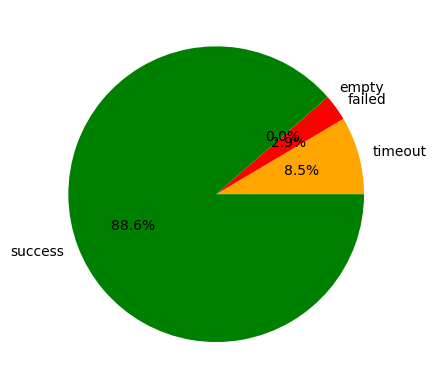

In [4]:
import matplotlib.pyplot as plt

print(f"Number of timed out requests: {len(df_timeout)}")
print(f"Number of failed requests: {len(df_fail)}")
print(f"Number of empty responses: {len(df_empty)}")
print(f"Number of successful responses: {len(df_successful)}")

labels = ["timeout", "failed", "empty", "success"]
sizes = [len(df_timeout), len(df_fail), len(df_empty), len(df_successful)]

fig, ax = plt.subplots()
ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=["orange", "red", "grey", "green"])

In [5]:
df_fail['error_type'] = df_fail.apply(lambda x: find_error_type(x['execution']), axis=1)

distinct_errors = df_fail.error_type.unique()

print(f"There is {len(distinct_errors)} types of errors: {', '.join(map(lambda x: str(x), distinct_errors))}")
for err in distinct_errors:
    if err == None:
        print(f"Number of {str(err)}: {len(df_fail.loc[df_fail['error_type'].isnull()])}")
    else:
        print(f"Number of {str(err)}: {len(df_fail.loc[df_fail['error_type'] == err])}")

print()

for err in distinct_errors:
    if err == None:
        print(f"Example of {str(err)}: {df_fail.loc[df_fail['error_type'].isnull()].iloc[0]['execution'][:256]}")
    else:
        print(f"Example of {str(err)}: {df_fail.loc[df_fail['error_type'] == err].iloc[0]['execution'][:256]}")

There is 3 types of errors: 500, 400, requests
Number of 500: 42
Number of 400: 36
Number of requests: 4

Example of 500: exception: 500 Server Error: Internal Server Error for url: https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=PREFIX+bd%3A+%3Chttp%3A%2F%2Fwww.bigdata.com%2Frdf%23%3E%0APREFIX+p%3A+%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2F%3E%0APREFIX+pq%3A+%3
Example of 400: exception: 400 Client Error: Bad Request for url: https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=PREFIX+schema%3A+%3Chttp%3A%2F%2Fschema.org%2F%3E%0APREFIX+xsd%3A+%3Chttp%3A%2F%2Fwww.w3.org%2F2001%2FXMLSchema%23%3E%0APREFIX+wdt%3A+%3Chttp%3A
Example of requests: exception: module 'requests.exceptions' has no attribute 'JSONDecodeError'


C:\Users\Alexis Strappazzon\AppData\Local\Temp\ipykernel_23040\3054370022.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fail['error_type'] = df_fail.apply(lambda x: find_error_type(x['execution']), axis=1)


## Investigating the Causes of Errors

Initially, we categorize errors based on their HTTP Status Codes, which bifurcate them into two primary categories: the 400 Client Error and the 500 Server Error. These codes offer a preliminary insight into whether the issue originates from the client or the server. However, they lack detailed diagnostic information. Notably, when Wikidata encounters an error and is unable to return a JSON response, it provides a stack trace instead. By applying regular expressions to analyze these stack traces, we can classify the various causes of errors, enhancing our understanding of the underlying issues.

error_type
500         42
400         36
requests     4
Name: count, dtype: int64


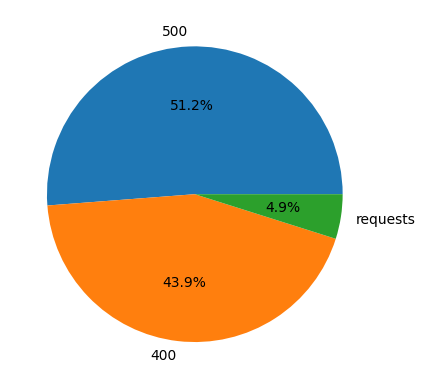

In [6]:
import matplotlib.pyplot as plt

value_counts = df_fail['error_type'].value_counts()
print(value_counts)

labels = list(df_fail['error_type'].value_counts().index)
sizes = list(value_counts)

fig, ax = plt.subplots()
ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%')

In [7]:
# from SPARQL_parser import SPARQL
#
# def is_correct_SPARQL_query(query):
#     try:
#         SPARQL(query)
#     except:
#         return False
#     return True

In [8]:
# df['correct_SPARQL_query'] = df.apply(lambda x: is_correct_SPARQL_query(x['query']), axis=1)

In [9]:
# df['correct_SPARQL_query']

In [10]:
# len(df.loc[df['correct_SPARQL_query'] == False])

In [11]:
df_fail['error_classified'] = df_fail.apply(lambda x: classify_all_errors(x['execution']), axis=1)

df_fail['ierror_classified'] = df_fail.apply(lambda x: ERROR_INDEX[x['error_classified'][0]] if isinstance(x['error_classified'], list) else None, axis=1)

C:\Users\Alexis Strappazzon\AppData\Local\Temp\ipykernel_23040\722804614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fail['error_classified'] = df_fail.apply(lambda x: classify_all_errors(x['execution']), axis=1)
C:\Users\Alexis Strappazzon\AppData\Local\Temp\ipykernel_23040\722804614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fail['ierror_classified'] = df_fail.apply(lambda x: ERROR_INDEX[x['error_classified'][0]] if isinstance(x['error_classified'], list) else None, axis=1)


### Analysis of 400 Client Error

Upon scrutinizing the "400 Client Error" category, we identified five primary error causes, ranked by their frequency of occurrence:
1. The query utilizes a prefix unrecognized by Wikidata.
2. Lexical errors emerge due to unescaped characters.
3. Parsing exceptions indicate improper query formatting. Manual inspection revealed remnants from web crawling or incomplete capture in some requests.
4. Parsing exceptions related to artificially added LIMIT clauses. While the base query may be correctly formatted, appending the LIMIT clause can lead to breakdowns. Nevertheless, reformatting (e.g., adjusting curly braces) can often rectify the issue.
5. The SELECT expression contains non-aggregate variables.

Automatically rectifying these queries poses challenges. However, manual adjustments are feasible for errors 1, 2, 4, and 5. The complication with error type 3 lies in the incomplete data, as some queries lack conclusive segments.

#### Resolving Syntax Issues with Brackets in SPARQL Queries

In the analysis of query index 441, we encounter a syntax issue related to the placement of closing brackets. Specifically, the closing bracket of the implicit WHERE clause is positioned immediately before the VALUES clause, making the addition of a LIMIT clause syntactically incorrect. However, relocating this closing bracket to the end of the VALUES clause not only preserves the original results but also accommodates the inclusion of a LIMIT clause.

Challenge: Identifying a universal, trivial solution to this syntax issue remains elusive.

Below is the **non-functional** version of the query:
```sparql
SELECT ?item ?itemLabel WHERE {
  ?item wdt:P108 ?employer.
  FILTER(NOT EXISTS {
    ?item ?wdt _:b7.
    ?wdt (^wikibase:directClaim/wdt:P31/(wdt:P279*)) wd:Q18614948.
  })
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
values (?employer) {(wd:Q1138080)}
LIMIT 10
```
Conversely, the **functional** version of the query is as follows:

```sparql
SELECT ?item ?itemLabel WHERE {
  ?item wdt:P108 ?employer.
  FILTER(NOT EXISTS {
    ?item ?wdt _:b7.
    ?wdt (^wikibase:directClaim/wdt:P31/(wdt:P279*)) wd:Q18614948.
  })
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
  VALUES ?employer {
    wd:Q1138080
  }
}
LIMIT 10
```

As previously mentioned, the resolution of this issue can be as straightforward as adjusting the placement of curly braces within certain queries.


error_classified
[undefined prefix]    32
[parse exception]      4
Name: count, dtype: int64


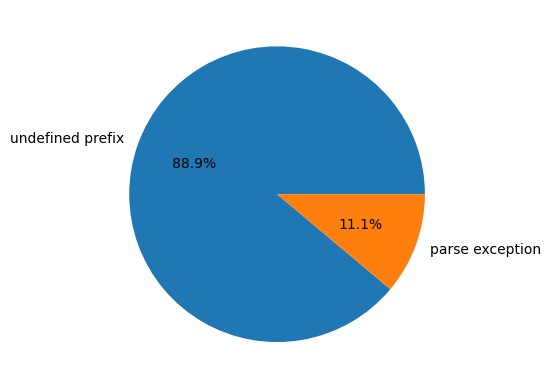

In [12]:
import matplotlib.pyplot as plt

df_error400 = df_fail.loc[df_fail['error_type'] == '400']

value_counts = df_error400.error_classified.value_counts()
print(value_counts)

labels = list(map(lambda x: ", ".join(x), list(df_error400.error_classified.value_counts().index)))
sizes = list(value_counts)

fig, ax = plt.subplots()
ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%')

### Analysis of 500 Server Error

[//]: # (Intriguingly, some queries initially labeled as non-functional were, upon closer scrutiny, found to be operational.)

Upon a detailed examination of queries triggering a "500 Server Error", three distinct categories emerge. However, a significant majority of 500 errors are attributable to Stack Overflow issues, followed by failures in the GeoSpatialSearch due to an inability to interpret inputs as geographical points. Additionally, a solitary query was preemptively terminated due to an excessively long estimated execution time.

The pathway to rectifying these queries remains nebulous. With the exception of GeoSpatialSearchException errors, where inputs might be more precisely defined, modifying other queries to reduce recursion or data usage could be a viable strategy. Similar to the issues categorized under "400 Client Error," these too likely necessitate manual intervention, given the complexities involved in automating such corrections.


error_classified
[stack overflow]                                                     35
[GeoSpatialSearchException: input could not be resolved as point]     7
Name: count, dtype: int64


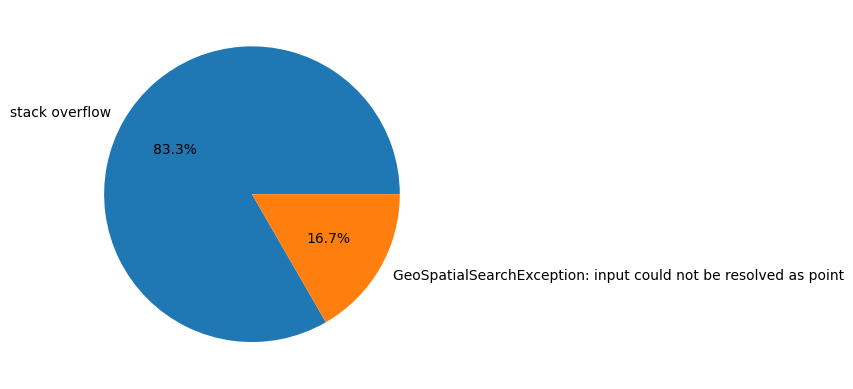

In [13]:
import matplotlib.pyplot as plt

df_error500 = df_fail.loc[df_fail['error_type'] == '500']

value_counts = df_error500.error_classified.value_counts()
print(value_counts)

labels = list(map(lambda x: ", ".join(x), list(df_error500.error_classified.value_counts().index)))
sizes = list(value_counts)

fig, ax = plt.subplots()
ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%')

## Evaluating the Impact of the Added LIMIT Clause on Query Integrity

To manage computational resources efficiently, we append a "LIMIT" clause to queries that lack one and are not structured as "COUNT" queries. This strategy addresses scenarios where query responses can be excessively voluminous; indeed, a previous instance without the LIMIT clause produced a combined file size of 2.9GB.

It's imperative to ascertain that this pragmatic insertion of the LIMIT clause doesn't inadvertently disrupt a significant number of queries. Preliminary findings indicate that certain "400 Client Error" instances were precipitated by the added LIMIT clause. This necessitates a thorough examination to ensure that such an issue isn't prevalent across other queries.

Within our Pandas dataframe, the original and modified queries are respectively designated as `query` and `executed_query`, facilitating a comparative analysis.

In [14]:
df_new_exec = df_fail[['query', 'execution', 'error_type', 'error_classified', 'ierror_classified']].copy()
df_new_exec['new_execution'] = df_new_exec.apply(lambda x: send_query_to_api(x['query']), axis=1)
df_new_exec['new_error_type'] = df_new_exec.apply(lambda x: find_error_type(x['new_execution']), axis=1)
df_new_exec['new_error_classified'] = df_new_exec.apply(lambda x: classify_all_errors(x['new_execution']), axis=1)
df_new_exec['inew_error_classified'] = df_new_exec.apply(lambda x: ERROR_INDEX[x['new_error_classified'][0]] if isinstance(x['new_error_classified'], list) else None, axis=1)

In [15]:
n_limit_errors = len(df_fail)
df_new_exec_fail = df_new_exec.loc[~df_new_exec['new_error_type'].isnull()]
n_no_limit_errors = len(df_new_exec_fail)

print(f"Number of error queries with limit: {n_limit_errors}")
print(f"Number of error queries without limit: {n_no_limit_errors}")
print(f"Does LIMIT is breaking some queries? {'yes' if n_limit_errors != n_no_limit_errors else 'no'}")

parse_exception_limit_index = ERROR_INDEX['parse exception due to limit']

parse_exception_limit = df_new_exec.query("ierror_classified == @parse_exception_limit_index")
n_parse_exception_limit = len(parse_exception_limit)

parse_exception_no_limit = df_new_exec.query("inew_error_classified == @parse_exception_limit_index")
n_parse_exception_no_limit = len(parse_exception_no_limit)

print()
print(f"How many 'parse exception due to limit' there is in the original query: {n_parse_exception_no_limit}")
print(f"How many 'parse exception due to limit' there is in the modified query: {n_parse_exception_limit}")

n_no_more_error = len(parse_exception_limit.query("new_error_type != new_error_type"))
same_error = parse_exception_limit.query("error_type == new_error_type")
n_same_error = len(same_error)
not_same_error = parse_exception_limit.query("error_type != new_error_type and new_error_type == new_error_type")
n_not_same_error = len(not_same_error)

print()
print(f"Understanding what went wrong with adding the LIMIT:")
print(f"\t{n_no_more_error} queries are working fine without LIMIT")
print()
print(f"\t{n_same_error} queries have the same error type")
if n_same_error > 0:
    limit = min(n_same_error, 3)
    
    print(f"\tShowing {limit} of {n_same_error} error classified that have the same 'error_type' but not the same 'error_classified':")
    
    for i, x in list(same_error.iterrows())[:limit]:
        print(f"\t\tThe query number {i} first had {x['error_classified']} and then {x['new_error_classified']}")

print()
print(f"\t{n_not_same_error} queries have another error type")
if n_not_same_error > 0:
    limit = min(n_not_same_error, 3)
    
    print(f"\tShowing {limit} of {n_not_same_error} error classified that didn't have the same 'error_type':")
    
    for i, x in list(not_same_error.iterrows())[:limit]:
        print(f"\t\tThe query number {i} first had {x['error_type']} and {x['error_classified']} and then {x['new_error_type']} and {x['new_error_classified']}")

print()
print(f"What is the difference in number of failed queries between original and modified: {abs(n_limit_errors - n_no_limit_errors)}")
print(f"Does it match with the queries that are working without the limit? {'no' if abs(n_limit_errors - n_no_limit_errors) != n_no_more_error else 'yes'}")

fail_and_same_error_type = df_new_exec_fail.query("error_type == new_error_type")
n_fail_and_same_error_type = len(fail_and_same_error_type)
fail_and_same_error_type_and_same_error_classified = df_new_exec_fail.query("error_type == new_error_type and error_classified == new_error_classified")
n_fail_and_same_error_type_and_same_error_classified = len(fail_and_same_error_type_and_same_error_classified)

print()
print(f"In the context of both executions failed ({n_no_limit_errors} queries):")

print()
print(f"\tHow many have the same 'error_type': {n_fail_and_same_error_type}")

if n_fail_and_same_error_type != n_no_limit_errors:
    fail_and_not_same_error_type = df_new_exec_fail.query("error_type != new_error_type")
    n_fail_and_not_same_error_type = len(fail_and_not_same_error_type)
    limit = min(n_fail_and_not_same_error_type, 3)
    
    print(f"\tShowing {limit} of {n_fail_and_not_same_error_type} queries that didn't have the same 'error_type':")
    
    for i, x in list(fail_and_not_same_error_type.iterrows())[:limit]:
        print(f"\t\tThe query number {i} first had {x['error_type']} and then {x['new_error_type']}")

print()
print(f"\tHow many have the same 'error_type' and 'error_classified': {n_fail_and_same_error_type_and_same_error_classified}")

if n_fail_and_same_error_type_and_same_error_classified != n_fail_and_same_error_type:
    fail_and_same_error_type_but_not_error_classified = df_new_exec_fail.query("error_type == new_error_type and error_classified != new_error_classified")
    n_fail_and_same_error_type_but_not_error_classified = len(fail_and_same_error_type_but_not_error_classified)
    limit = min(n_fail_and_same_error_type_but_not_error_classified, 3)
    
    print(f"\tShowing {limit} of {n_fail_and_same_error_type_but_not_error_classified} queries that had the same 'error_type' but didn't have the same 'error_classified':")
    
    for i, x in list(fail_and_same_error_type_but_not_error_classified.iterrows())[:limit]:
        print(f"\t\tThe query number {i} first had {x['error_classified']} and then {x['new_error_classified']}")

Number of error queries with limit: 82
Number of error queries without limit: 81
Does LIMIT is breaking some queries? yes

How many 'parse exception due to limit' there is in the original query: 0
How many 'parse exception due to limit' there is in the modified query: 0

Understanding what went wrong with adding the LIMIT:
	0 queries are working fine without LIMIT

	0 queries have the same error type

	0 queries have another error type

What is the difference in number of failed queries between original and modified: 1
Does it match with the queries that are working without the limit? no

In the context of both executions failed (81 queries):

	How many have the same 'error_type': 78
	Showing 3 of 3 queries that didn't have the same 'error_type':
		The query number 550 first had requests and then server timeout
		The query number 889 first had requests and then server timeout
		The query number 1253 first had requests and then server timeout

	How many have the same 'error_type' and 'e

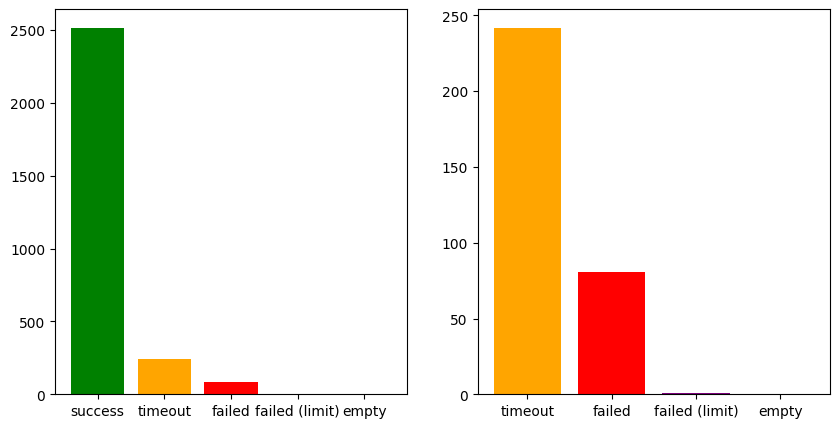

In [16]:
import matplotlib.pyplot as plt


labels = ["success", "timeout", "failed", "failed (limit)", "empty"]
sizes = [len(df_successful), len(df_timeout), n_no_limit_errors, n_limit_errors - n_no_limit_errors, len(df_empty)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1 = ax1.bar(labels, sizes, color=["green", "orange", "red", "purple", "grey"])
ax2 = ax2.bar(labels[1:], sizes[1:], color=["orange", "red", "purple", "grey"])

## Conclusion

Initially, we visualized the proportion of successful query executions in comparison to timed-out requests, empty responses, and failed requests. Our findings indicated that a predominant majority of queries were operational, yielding results effectively. Within the remaining categories, timed-out requests constituted the largest segment, followed by failed executions.

Subsequently, our analysis of failed requests involved categorizing them into two primary types: "400 Client Error" and "500 Server Error". A deeper examination of each category provided insights into the underlying issues. A minor fraction of queries failed due to the inclusion of a LIMIT clause intended to minimize computational load, which inadvertently led to their failure. Other queries encountered distinct issues such as undefined prefixes, stack overflow, parsing, or lexical errors. Although many of these errors are rectifiable manually, devising an automated solution presents significant challenges. Furthermore, the incomplete nature of the data crawling process has resulted in certain queries lacking comprehensive conclusions, thereby complicating the correction process.